# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering, DBSCAN, SpectralClustering
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer

# Loading Dataset

In [2]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9110, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Selecting Columns for Analysis

We eliminate all the columns that are either of the following
* Assigned after other values are measured from readings
* Contain ID or name attributes
* Are error attributes

There are namely [6 types](http://www.sun.org/encyclopedia/exoplanets) of exoplanets

In [3]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [4]:
print(len(TO_USE))
df[TO_USE].head()

19


,koi_fpflag_ec,koi_time0bk,dec,koi_teq,koi_prad,koi_duration,koi_fpflag_nt,koi_period,koi_kepmag,koi_impact,koi_model_snr,koi_slogg,koi_srad,koi_steff,ra,koi_fpflag_co,koi_insol,koi_depth,koi_fpflag_ss
0,0,170.538750,48.141651,793.0,2.26,2.95750,0,9.488036,15.347,0.146,35.8,4.467,0.927,5455.0,291.93423,0,93.59,615.8,0
1,0,162.513840,48.141651,443.0,2.83,4.50700,0,54.418383,15.347,0.586,25.8,4.467,0.927,5455.0,291.93423,0,9.11,874.8,0
2,0,175.850252,48.134129,638.0,14.60,1.78220,0,19.899140,15.436,0.969,76.3,4.544,0.868,5853.0,297.00482,0,39.30,10829.0,1
3,0,170.307565,48.285210,1395.0,33.46,2.40641,0,1.736952,15.597,1.276,505.6,4.564,0.791,5805.0,285.53461,0,891.96,8079.2,1
4,0,171.595550,48.226200,1406.0,2.75,1.65450,0,2.525592,15.509,0.701,40.9,4.438,1.046,6031.0,288.75488,0,926.16,603.3,0


# Extracting Dataframe Subset

We extract only those rows which are `CONFIRMED` examples i.e. the `disposition value` is `CONFIRMED`.

In [5]:
new_df = df[df["koi_disposition"] == "CONFIRMED"]
print(new_df.shape)
new_df.head()

(2292, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,6,10872983,K00756.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
6,7,10872983,K00756.02,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


# Extracting Values

In [6]:
X = new_df[TO_USE].values
y = new_df["koi_disposition"].values

In [7]:
X_scaler = StandardScaler()
X_scaler.fit(X)
X_scaled = X_scaler.transform(X)

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_2d = pca.transform(X_scaled)

In [8]:
X_2d.shape

(2292, 2)

# Visualisation

In [9]:
def elbowVisualiser(model, metric=None):
    if metric is None:
        visualizer = KElbowVisualizer(model, k=(4,12))
    else:
        visualizer = KElbowVisualizer(model, k=(4,12), metric=metric)
    visualizer.fit(X)
    visualizer.show()
    
    
def interclusterDistanceVisualisation(model):
    visualizer = InterclusterDistance(model)
    visualizer.fit(X)
    visualizer.show()
    

def silhouetteVisualisation(model):
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(X)
    visualizer.show()
    
    
def viewKMeansScatter(model):
    clust_labels = model.predict(X)
    temp_df = new_df[TO_USE].copy()
    temp_df["Class"] = clust_labels
    unique_classes = list(range(model.n_clusters))
    print(temp_df.groupby("Class").median())
    for cls in unique_classes:
        sub_df = temp_df[temp_df["Class"] == cls]
        temp_X = sub_df[[col for col in temp_df.columns if col != "Class"]].values
        temp_X_2d = pca.transform(X_scaler.transform(temp_X))
        #print(X_2d.shape)    
        plt.scatter(temp_X_2d[:, 0], temp_X_2d[:, 1], cmap="plasma", label=cls)
    plt.legend()
    
def viewAggScatter(model):
    clust_labels = model.fit_predict(X)
    temp_df = new_df[TO_USE].copy()
    temp_df["Class"] = clust_labels
    unique_classes = list(range(model.n_clusters))
    print(temp_df.groupby("Class").median())
    for cls in unique_classes:
        sub_df = temp_df[temp_df["Class"] == cls]
        temp_X = sub_df[[col for col in temp_df.columns if col != "Class"]].values
        temp_X_2d = pca.transform(X_scaler.transform(temp_X))
        #print(X_2d.shape)    
        plt.scatter(temp_X_2d[:, 0], temp_X_2d[:, 1], cmap="plasma", label=cls)
    plt.legend()
    
    
def getVisualisationPCA(X, y):
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X)
    
    pca_df = pd.DataFrame(
        data = principal_components,
        columns = ['principal component 1', 'principal component 2']
    )
    
    pca_df["TARGET"] = y
    labels = np.unique(y)
    
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    plt.grid()
    for label, color in zip(labels, colors):
        indicesToKeep = pca_df['TARGET'] == label
        plt.scatter(
            pca_df.loc[indicesToKeep, 'principal component 1'],
            pca_df.loc[indicesToKeep, 'principal component 2'],
            c = color,
            label=label
        )
        
    plt.legend()
    plt.grid()            

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


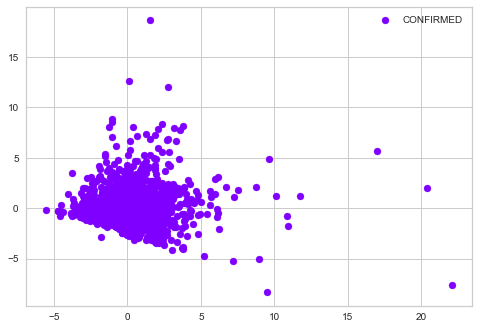

In [10]:
getVisualisationPCA(X, y)

# KMeans Clustering

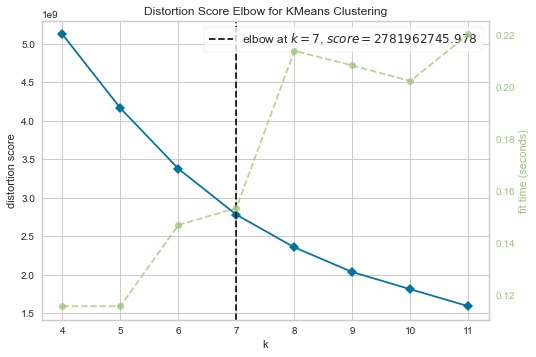

In [11]:
model = KMeans(random_state=0)
elbowVisualiser(model)

In [12]:
K=7
model = KMeans(K, max_iter=500, random_state=0)
model.fit(X)

KMeans(max_iter=500, n_clusters=7, random_state=0)

       koi_fpflag_ec  koi_time0bk        dec  koi_teq  koi_prad  koi_duration  \
Class                                                                           
0                0.0   139.513825  44.518215    850.0     2.090      4.014200   
1                0.0   170.047995  41.944069    730.0    12.190      4.272100   
2                0.0   132.476340  44.089634   1783.5     1.450      1.935500   
3                0.0   169.998236  43.449030    619.0     8.970      5.155675   
4                0.0   126.183673  44.545266   3372.5    11.830      2.152685   
5                0.0   149.943530  44.149319    545.0     2.190      2.938500   
6                0.0   161.936543  45.125620   1012.0    10.985      3.224025   

       koi_fpflag_nt  koi_period  koi_kepmag  koi_impact  koi_model_snr  \
Class                                                                     
0                0.0   11.833289     14.2710      0.4145          27.05   
1                0.0    3.905082     15.1270 

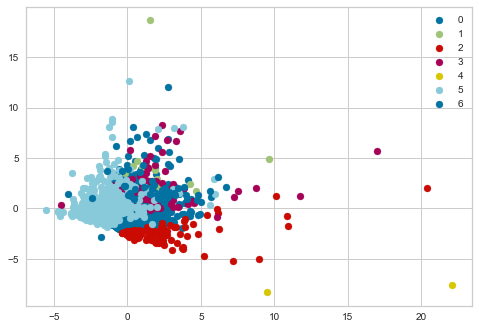

In [13]:
viewKMeansScatter(model)

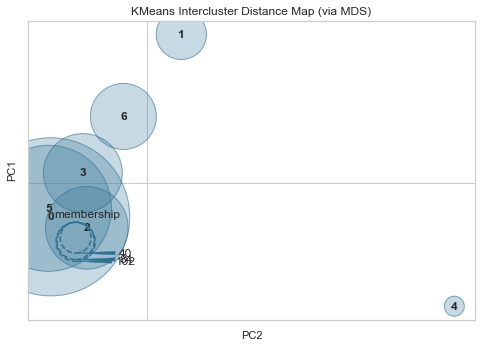

In [14]:
interclusterDistanceVisualisation(model)

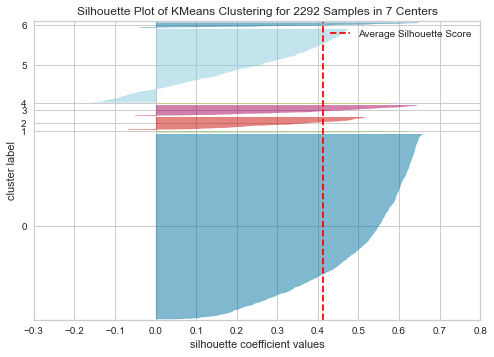

In [15]:
silhouetteVisualisation(model)

# Agglomerative Clustering

In [16]:
def plot_dendrogram(X):
    de = dendrogram(linkage(X, method='ward'))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.grid()
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")    

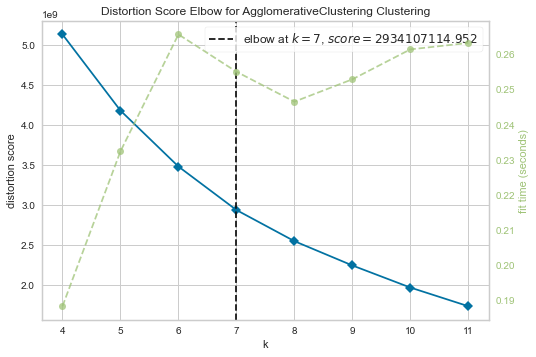

In [17]:
model = AgglomerativeClustering()
elbowVisualiser(model)

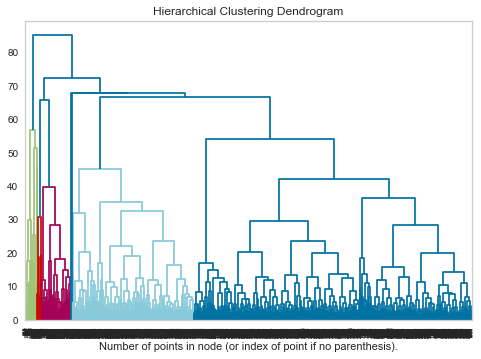

In [18]:
plot_dendrogram(X_scaled)

       koi_fpflag_ec  koi_time0bk        dec  koi_teq  koi_prad  koi_duration  \
Class                                                                           
0                0.0   165.150671  43.680962    769.0      9.11      4.301000   
1                0.0   132.472130  44.292549   1774.0      1.46      1.919000   
2                0.0   149.414335  44.149569    585.5      2.34      3.160100   
3                0.0   126.183673  44.545266   3372.5     11.83      2.152685   
4                0.0   170.047995  41.944069    730.0     12.19      4.272100   
5                0.0   138.650170  44.521124    899.0      1.95      4.106350   
6                0.0   169.890622  45.439678   1017.0     11.30      2.505870   

       koi_fpflag_nt  koi_period  koi_kepmag  koi_impact  koi_model_snr  \
Class                                                                     
0                0.0   12.611904     14.6510       0.284         370.80   
1                0.0    1.340597     14.1130 

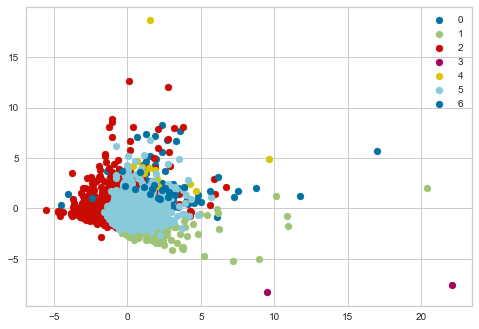

In [19]:
K=7
model = AgglomerativeClustering(n_clusters=K)
viewAggScatter(model)